In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
import glob,os
from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2544971328408771187,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8561947695760106714
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7786181824176503511
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 23228448768
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11302149826802823852
 physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [2]:
data_dir = '/home/Downloads/celeba/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                    data_dir,
                    label_mode = None,
                    batch_size = 1,
                    image_size = (64,64))
train_ds = train_ds.unbatch()
N_IMAGES = 100000
train_ds = train_ds.take(N_IMAGES)
BUFFER_SIZE = 10000
BATCH_SIZE = 128
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x: (x-127.5)/127.5)

Found 202599 files belonging to 1 classes.


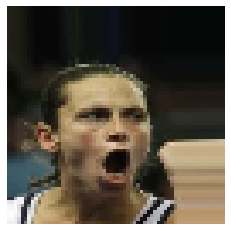

In [3]:
for item in train_ds.take(1):
    plt.imshow(item[0,...]*0.5+0.5)
    plt.axis('off')

In [4]:
dir_name = 'images/resnet_celeb2/'
for f in glob.glob(dir_name+'*.png'):
    os.remove(f)

In [5]:
class ResnetUpSampleBlock(tf.keras.layers.Layer):
    def __init__(self, filter_size,kernel_size):
        super(ResnetUpSampleBlock, self).__init__(name='')
        
        self.conv2a = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3), strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size, strides=(2,2), 
                                                      padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2DTranspose(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                                      padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2DTranspose(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)
    
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.relu(x)
    
class ResnetDownSampleBlock(tf.keras.layers.Layer):
    def __init__(self,filter_size, kernel_size):
        super(ResnetDownSampleBlock, self).__init__(name='')

        self.conv2a = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3), strides=(1,1),
                                             padding='same',use_bias=False)
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filter_size, kernel_size, strides=(2,2), 
                                             padding='same',use_bias=False)
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filter_size, kernel_size=(3, 3),strides=(1,1), 
                                             padding='same',use_bias=False)
        self.bn2c = tf.keras.layers.BatchNormalization()
        
        self.convReshape = tf.keras.layers.Conv2D(filter_size,kernel_size=(1,1),strides=(2,2),
                                                 padding='same',use_bias=False)

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)
        
        input_tensor_reshaped = self.convReshape(input_tensor)
        x += input_tensor_reshaped
        return tf.nn.leaky_relu(x)

In [6]:
def make_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(ResnetUpSampleBlock(256,3))
    assert model.output_shape == (None,16,16,256)
    model.add(layers.BatchNormalization())
    model.add(ResnetUpSampleBlock(256,3))
    assert model.output_shape == (None,32,32,256)
    model.add(layers.BatchNormalization())
    model.add(ResnetUpSampleBlock(256,3))
    assert model.output_shape == (None,64,64,256)
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', 
                            use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64 , 64, 3)

    return model


def make_discriminator():
    model = tf.keras.Sequential()
    model.add(ResnetDownSampleBlock(128,3))
    model.add(layers.BatchNormalization())
    model.add(ResnetDownSampleBlock(128,3))
    model.add(layers.BatchNormalization())
    model.add(ResnetDownSampleBlock(128,3))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [7]:
latent_dim = 128
generator = make_generator(latent_dim)
discriminator = make_discriminator()

In [8]:
def generator_loss():
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    fake_images = generator(z,training=True)
    fake_output = discriminator(fake_images,training=True)
    g_loss = -tf.reduce_mean(tf.math.log(fake_output))
    return g_loss

def discriminator_loss(real_images):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    fake_images = generator(z,training=True)
    fake_output = discriminator(fake_images,training=True)
    real_output = discriminator(real_images,training=True)
    d_loss_real = tf.reduce_mean(tf.math.log(real_output))
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-fake_output))
    d_loss = d_loss_real+d_loss_fake
    return -d_loss

In [9]:
def save_generator_samples(epoch):
    z = tf.random.normal([16,latent_dim])
    images = generator(z,training=False)
    fig = plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i]*0.5+0.5)
        plt.axis('off')
    plt.suptitle('epoch: %03d'%(epoch))
    plt.savefig(dir_name+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

In [10]:
LR = 1e-4
BETA_1 = 0.5
generator_opt = tf.keras.optimizers.Adam(learning_rate=LR,beta_1=BETA_1)
discriminator_opt = tf.keras.optimizers.Adam(learning_rate=LR,beta_1=BETA_1)

@tf.function
def train_step(real_images): 
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_loss = generator_loss()
        d_loss = discriminator_loss(real_images)
       
    g_grad = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grad = d_tape.gradient(d_loss, discriminator.trainable_variables)
    
    generator_opt.apply_gradients(zip(g_grad,generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(d_grad,discriminator.trainable_variables))
    
    return d_loss,g_loss

def train(dataset, epochs):
    t = trange(epochs)
    for epoch in t:
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
            t.set_description("D loss: %0.3f G loss: %0.3f" %(d_loss.numpy(),g_loss.numpy()))
            t.refresh()
        save_generator_samples(epoch)
EPOCHS = 100
train(train_ds,EPOCHS)

D loss: 0.293 G loss: 2.664:   3%|▎         | 3/100 [16:41<8:59:38, 333.80s/it]  


KeyboardInterrupt: 

In [ ]:
import glob
import imageio
anim_file = 'resnet_gan_celeb2.gif'

with imageio.get_writer(anim_file, mode='I',fps=1) as writer:
    filenames = glob.glob(dir_name+'image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_samples(model,size):
    z = tf.random.normal([size**2,latent_dim])
    images = model(z,training=False)
    fig = plt.figure(figsize=(7,7))
    for i in range(size**2):
        plt.subplot(size,size,i+1)
        plt.imshow(images[i]*0.5+0.5)
        plt.axis('off')
    plt.show()
    plt.pause(0.05)

In [ ]:
plot_samples(generator,5)

In [ ]:
#saving and loading model
generator.compile(generator_opt)
generator.save('models/resnet_celeb/generator')

discriminator.compile(discriminator_opt)
discriminator.save('models/resnet_celeb/disciminator')

In [ ]:
generator_new = tf.keras.models.load_model('models/resnet_celeb/generator')
plot_samples(generator_new,5)